In [32]:
%matplotlib inline
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12., 8.)

## Exercise 1

Use the `curve_fit` function to fit a quadratic polynomial function to the data, plot the result and compare the erro with the previous fits.

In [2]:
a = -1
b = 5

def f(x, a, b):
    return np.exp(a * x) + b

x = np.linspace(0, 5, 100)
y = f(x, a, b) + np.random.normal(0, 0.1, 100)

In [25]:
from scipy.optimize import curve_fit

def f_quadratic(x, a, b, c):
    return a*x**2 + b**x + c

quad_params, quad_covariance_matrix = curve_fit(f_quadratic, x, y)
y_fit = f_quadratic(x, *quad_params)
error = ((y - y_fit)**2).sum()

print('parameters: {}'.format(quad_params))
print('error: {}'.format(error))

parameters: [2.32254551e-03 4.26848523e-01 4.93862035e+00]
error: 1.1261221169533036


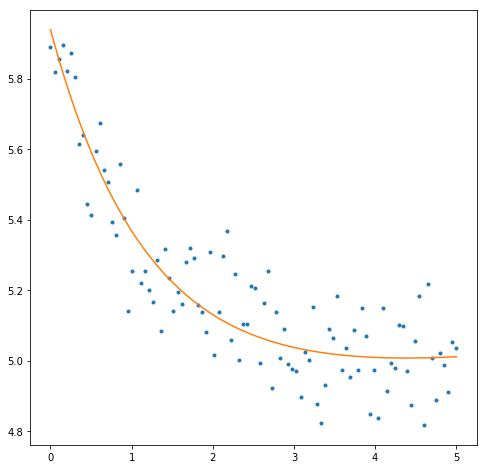

In [26]:
plt.plot(x, y, '.')
plt.plot(x, y_fit)

<a id=exercise_2></a>
### Exercise 2

Do the same to estimate the parameters of a gaussian distribution.

Generate a sample of a normal distribution with $\mu = 10$ and $\sigma = 6$

pdf:

$$
f(x, \mu, \sigma) =  \frac{1}{\sqrt{2 \pi}} \mathrm{e}^{-0.5 \frac{(x - \mu)^2}{\sigma^2}}
$$

Minimize the negative log-likelihood:

$$
-\log(\mathcal{L}) = -\sum_{i = 0}^N \log\bigl( \frac{1}{\sqrt{2 \pi}} \mathrm{e}^{-0.5 \frac{(x_i - \mu)^2}{\sigma^2}}  \bigr)
$$

You can make use of the `norm.rvs` and `norm.pdf` functions to generate the sample and define the function to be minimized.

/home/francesc/virtualenvs/python3_master_IFAE/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


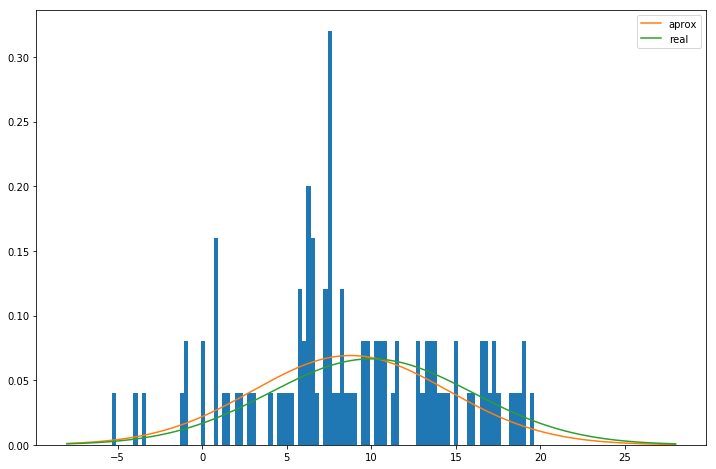

In [33]:
from scipy.optimize import minimize
from scipy.stats import norm

x = norm.rvs(loc=10, scale=6, size=100)

def negative_log_likelihood(params, x):
    mu, sigma = params
    neg_l = -np.sum(np.log(norm.pdf(x, mu, sigma)))
    return neg_l


result = minimize(
    negative_log_likelihood,
    x0=(0., 1.),   # initial guess
    args=(x, ),            # additional arguments for the function to minimize
    bounds=[
        (None, None),      # no bounds for mu
        (1e-32, None)         # sigma > 0
    ],
    method='L-BFGS-B', # method that supports bounds
)

x_plot = np.linspace(-8, 28, 1000)

plt.hist(x, bins=100, normed=True)
plt.plot(x_plot, norm.pdf(x_plot, *result.x), label='aprox')
plt.plot(x_plot, norm.pdf(x_plot, 10., 6.), label='real')
plt.legend();

### Exercise 3

Apply the `trapz` function to calculate:

$$
\int_{-4}^{4} \sqrt[3]{(1 - x^3)} dx
$$

**Hint** use the `np.cbrt` function

In [47]:
from scipy.integrate import trapz

def f(x):
    x0 = np.cbrt(1 - x**3)
    return x0

/home/francesc/virtualenvs/python3_master_IFAE/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in power
  


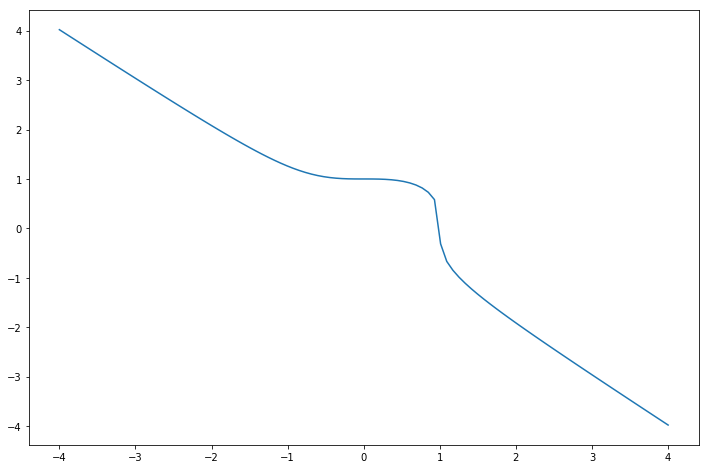

In [52]:
x = np.linspace(-4, 4, 100)
y = f(x)
plt.plot(x, y)

In [53]:
trapz(x, y)

-2.3017199724935655